## Installing & Importing Libraries

In [4]:
!pip install pandas numpy matplotlib mplfinance prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from prophet import Prophet
from datetime import datetime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.4 MB/s eta 0:00:00


## Loading Data (Daily Stock Price - HBL 2018 Jan - 2025 Aug)

In [13]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('Habib Bank Stock Price History.csv')
print(df.head())


Saving Habib Bank Stock Price History.csv to Habib Bank Stock Price History.csv
         Date   Price    Open    High     Low     Vol. Change %
0  01/01/2018  173.97  168.99  174.45  166.00  887.10K    4.12%
1  01/02/2018  179.67  174.00  180.00  173.50    2.62M    3.28%
2  01/03/2018  178.06  178.60  182.00  176.55    1.21M   -0.90%
3  01/04/2018  181.79  177.90  182.80  177.00    1.74M    2.09%
4  01/05/2018  185.87  181.50  187.50  181.00    2.92M    2.24%


## Preprocessing the Data

In [14]:
# Rename columns
df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change%']

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Convert Volume to number
df['Volume'] = df['Volume'].str.replace('K','e3').str.replace('M','e6')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

# Sort oldest to newest
df = df.sort_values('Date')


## Visualizing Data (CandleSticks)

In [17]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close']
)])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

 ##  Model for prediction (Prophet)

In [18]:
df_prophet = df[['Date', 'Close']].rename(columns={'Date':'ds','Close':'y'})
model = Prophet()
model.fit(df_prophet)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcxhdu0b/nhqkby22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcxhdu0b/wucxctqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55381', 'data', 'file=/tmp/tmpbcxhdu0b/nhqkby22.json', 'init=/tmp/tmpbcxhdu0b/wucxctqe.json', 'output', 'file=/tmp/tmpbcxhdu0b/prophet_model286yksvo/prophet_model-20250804082051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##### Measuring Model Error on Historical Data

RMSE on training data: 10.75 PKR
MAPE on training data: 6.64%


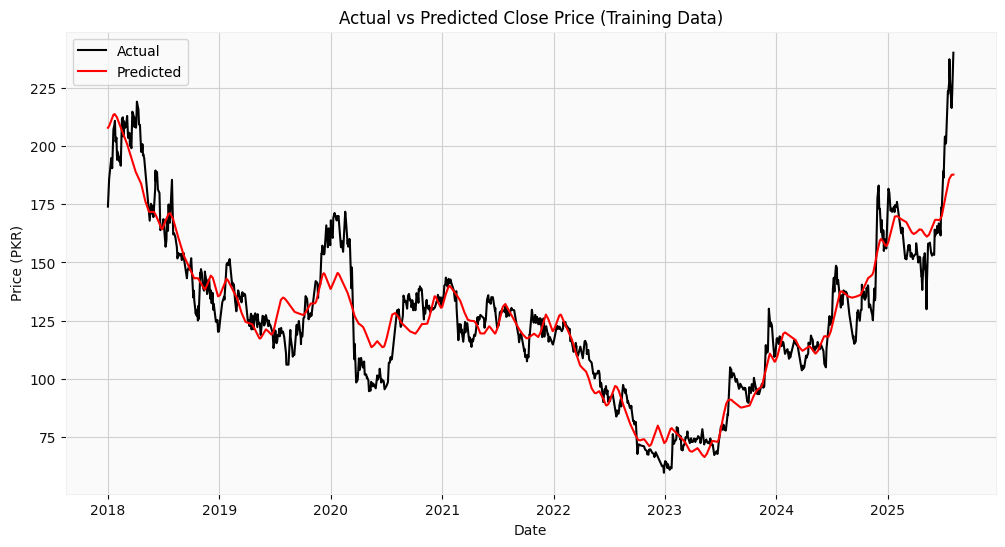

In [32]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(df_prophet['y'], forecast_in_sample['yhat'])
rmse = np.sqrt(mse)

print(f"RMSE on training data: {rmse:.2f} PKR")

# Error Rate
mape = np.mean(np.abs((df_prophet['y'] - forecast_in_sample['yhat']) / df_prophet['y'])) * 100
print(f"MAPE on training data: {mape:.2f}%")

# Plotting Chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', color='black')
plt.plot(forecast_in_sample['ds'], forecast_in_sample['yhat'], label='Predicted', color='red')
plt.title('Actual vs Predicted Close Price (Training Data)')
plt.xlabel('Date')
plt.ylabel('Price (PKR)')
plt.legend()
plt.show()


## Forecast future dates

In [24]:
# Create future dataframe ~1 year ahead
future = model.make_future_dataframe(periods=400)
forecast = model.predict(future)

# Get actual close price on 1st Aug 2025
actual_price = df[df['Date'] == '2025-08-01']['Close'].values[0]
print(f"Actual close price on 2025-08-01: {actual_price:.2f} PKR")

# Predict future prices
target_dates = pd.to_datetime(['2025-09-01', '2025-12-01', '2026-06-01'])
predicted = forecast[forecast['ds'].isin(target_dates)][['ds','yhat']]\
    .rename(columns={'ds':'Date','yhat':'Predicted_Close'})

# Print Prices
print("\nPredicted future prices:")
print(predicted.to_string(index=False))


Actual close price on 2025-08-01: 231.37 PKR

Predicted future prices:
      Date  Predicted_Close
2025-09-01       185.049390
2025-12-01       207.077703
2026-06-01       217.782443


## Investment calculation

In [28]:
# Buy on 2025-06-02
buy_date = pd.to_datetime('2025-06-02')
buy_price = df[df['Date'] == buy_date]['Close'].values[0]
investment = 10000  # PKR

print(f"Buy price on {buy_date.date()}: {buy_price:.2f} PKR")

# Predicted prices on target dates
target_dates = pd.to_datetime(['2025-09-01', '2025-12-01', '2026-06-01'])
predicted = forecast[forecast['ds'].isin(target_dates)][['ds','yhat']]\
    .rename(columns={'ds':'Date','yhat':'Predicted_Close'})

# Calculate profit for each target date
print("\nPredicted profit if you invest 10,000 PKR on 2025-06-02:")
for _, row in predicted.iterrows():
    future_price = row['Predicted_Close']
    profit = (future_price - buy_price) / buy_price * investment
    print(f"On {row['Date'].date()}: {profit:.0f} PKR")


Buy price on 2025-06-02: 153.24 PKR

Predicted profit if you invest 10,000 PKR on 2025-06-02:
On 2025-09-01: 2076 PKR
On 2025-12-01: 3513 PKR
On 2026-06-01: 4212 PKR
